In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pickle
import sklearn as sk
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from munkres import Munkres
import pandas as pd
from ktools import *
import igraph as ig
import leidenalg
import tqdm
from collections import defaultdict
import dill
import itertools

In [2]:
res = {}


In [3]:
label_colors = {"louvain":sns.color_palette()[0],
                "leiden": sns.color_palette()[1],
                "gn":sns.color_palette()[2]}

# Importing Data

Data Set

In [4]:
def create_adjacency(df:pd.DataFrame)->np.array:
    m = max(max(df["zero"].value_counts().index), max(df["one"].value_counts().index)) + 1
    A = np.zeros((m,m))
    a,b = df["zero"].to_numpy(dtype=int), df["one"].to_numpy(dtype=int)

    A[a,b] =1
            
    return A

In [5]:
data = pd.read_csv(r"data\email-Eu-core-temporal.txt.gz")
data = data.map(str.split)
series_d, series_0,  series_1, t = data.map(lambda x:(x[0], x[1])).values.flatten(),data.map(lambda x:x[0]).values.flatten(), data.map(lambda x:x[1]).values.flatten(), data.map(lambda x:x[2]).values.flatten()

series_d = pd.Series(series_d)
wt = pd.Series(series_d).value_counts()


to_integer = np.vectorize(int)
edges = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1), "d": series_d, "w": series_d.map(lambda x: wt[x])})


edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [6]:
edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [7]:
#handling the edges
data = pd.read_csv(r"data\email-Eu-core.txt.gz")
data = data.map(str.split)
series_0 = data.map(lambda x:x[0]).values.flatten()
series_1 = data.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)


df = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1)})
df = df.dropna()
df

,zero,one
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


In [8]:
# Handling the Labels
labels = pd.read_csv(r"data\email-Eu-core-department-labels.txt.gz")

labels= labels.map(str.split)
series_0 = labels.map(lambda x:x[0]).values.flatten()
series_1 = labels.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)
labels = pd.DataFrame({"node": to_integer(series_0), "label": to_integer(series_1)})
labels = labels.dropna()

In [9]:

comms = {label: list(labels[labels["label"] == label]["node"]) for label in labels["label"].unique()}
labels["community"] = labels["label"].map(comms)


In [10]:
A = create_adjacency(df)
eucore = nx.from_numpy_array(A)
nx.set_node_attributes(eucore, labels["community"], "community")
nx.set_node_attributes(eucore, labels["label"], "label")
eucore.remove_node(1004)


In [11]:
nx.attribute_assortativity_coefficient(eucore, "label")

0.06838781421256855

Random Networks


In [12]:
def import_random_state():
    random_state_integers = np.loadtxt("random_state_integers.txt")
    enc="MT19937"
    params = []
    with open(r'random_state_params.txt', 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]

            # add current item to the list
            params.append(x)

    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = float(params[2])

    params.insert(0,enc)
    params.insert(1, random_state_integers)
    
    return tuple(params)

In [13]:
np.random.set_state(import_random_state())

In [14]:
G_small = pickle.load(open('small50.pickle', 'rb'))

In [15]:
G_medium = pickle.load(open('medium250.pickle', 'rb'))

In [16]:
G_large = pickle.load(open('large250.pickle', 'rb'))

In [17]:
def create_gcl(G):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]

    return gcl

In [18]:
def create_lcl(comms,G):
    """create labels for the outcome communities commmunties
    """
    counter = 0    
    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    return lcl

# Creating Baselines

### Baseline Louvain

In [19]:
def baseline_metrics_louvain(G, n=20):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [nx.community.louvain_communities(G, weight=None) for _ in range(n)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(n):
        counter =0
        comms = nx.community.louvain_communities(G)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.median(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.median(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    return stats_dict

In [20]:
res["louvain_small"] =baseline_metrics_louvain(G_small)
res["louvain_small"]

{'a_modularity': 0.48050071739823574,
 'var_modularity': 0.000746238850253257,
 'a_nmi': 0.6891844599554084,
 'var_nmi': 0.0004245584347045486,
 'a_kappa': 0.11077859000147182,
 'var_kappa': 0.016274996116475655,
 'accuracy': 0.12872630870530027}

In [21]:
res["louvain_medium"] = baseline_metrics_louvain(G_medium)

In [22]:
res["louvain_large"] = baseline_metrics_louvain(G_large)

In [23]:
res["louvain_eucore"] = baseline_metrics_louvain(eucore)

### Baseline Leiden

In [24]:
def run_leiden(G):
    """"Runs the Leidein Algorithm in a graph G"""
    h = ig.Graph.from_networkx(G)
    partition = leidenalg.find_partition(h, leidenalg.ModularityVertexPartition, weights="weight")
    communities = [[] for _ in range(len(partition))]
    # Fill the communities with vertex indices
    for vertex, community in enumerate(partition.membership):
        communities[community].append(vertex)

    return communities    

In [25]:
def baseline_metrics_leiden(G, n=20):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [run_leiden(G) for _ in range(20)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []


    for _ in range(n):
        counter =0
        comms = run_leiden(G)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict



In [26]:
res["leiden_small"] = baseline_metrics_leiden(G_small)

In [27]:
res["leiden_medium"] = baseline_metrics_leiden(G_medium)

In [28]:
res["leiden_large"] = baseline_metrics_leiden(G_large)

In [29]:
res["leiden_eucore"] = baseline_metrics_leiden(eucore)

### Baseline GN

In [34]:
def baseline_metrics_gn(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}
    
    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]
    
    comp = nx.community.girvan_newman(G)
    
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)


    nx.community.girvan_newman(G)
    comp = nx.community.girvan_newman(G)
    gn = tuple(sorted(c) for c in next(comp))
 


    generated_communities = [{frozenset(c) for c in gn}] 
    print(generated_communities)
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    
    comms = frozenset(generated_communities[0]) 
    counter = 0


    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

    #calculating kappa   
    l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict

In [31]:
res["gn_small"] = baseline_metrics_gn(G_small,5)

here
<class 'tuple'>
here
<class 'tuple'>
[{frozenset({0, 32, 2, 3, 35, 39, 10, 11, 13, 45, 47, 49, 18, 19, 20, 25, 30}), frozenset({48}), frozenset({46, 14, 16, 23, 24}), frozenset({6}), frozenset({4, 5, 7, 8, 9, 12, 17, 21, 22, 26, 27, 28, 29, 31, 36, 37, 38, 40, 41, 42, 43}), frozenset({1, 34, 33, 44, 15})}]


In [35]:
res["gn_medium"] = baseline_metrics_gn(G_medium)


[{frozenset({249, 37, 127}), frozenset({39}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

In [36]:
res["gn_large"] =  baseline_metrics_gn(G_large, )

[{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [37]:
res["gn_eucore"] = baseline_metrics_gn(eucore,40)

[{frozenset({798}), frozenset({580}), frozenset({660}), frozenset({675}), frozenset({744}), frozenset({633}), frozenset({670}), frozenset({732}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190

In [38]:
res["gn_eucore"]

{'a_modularity': 0.003109299536853528,
 'var_modularity': 0.0,
 'a_nmi': 0.04093204857483724,
 'var_nmi': 0.0,
 'a_kappa': 0.00972239800885399,
 'var_kappa': 0.0}

In [39]:
modularities = [res[key]["a_modularity"] for key in res ]
nmis = [res[key]["a_nmi"] for key in res ]
kappas = [res[key]["a_kappa"] for key in res ]



colors = [label_colors[str(key).split("_")[0]] for key in res]
res.keys()


dict_keys(['louvain_small', 'louvain_medium', 'louvain_large', 'louvain_eucore', 'leiden_small', 'leiden_medium', 'leiden_large', 'leiden_eucore', 'gn_small', 'gn_medium', 'gn_large', 'gn_eucore'])

C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_17328\2088141532.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_17328\2088141532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_17328\2088141532.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")


Text(0.5, 0.98, 'Performance Metrics of Baseline Algorithms')

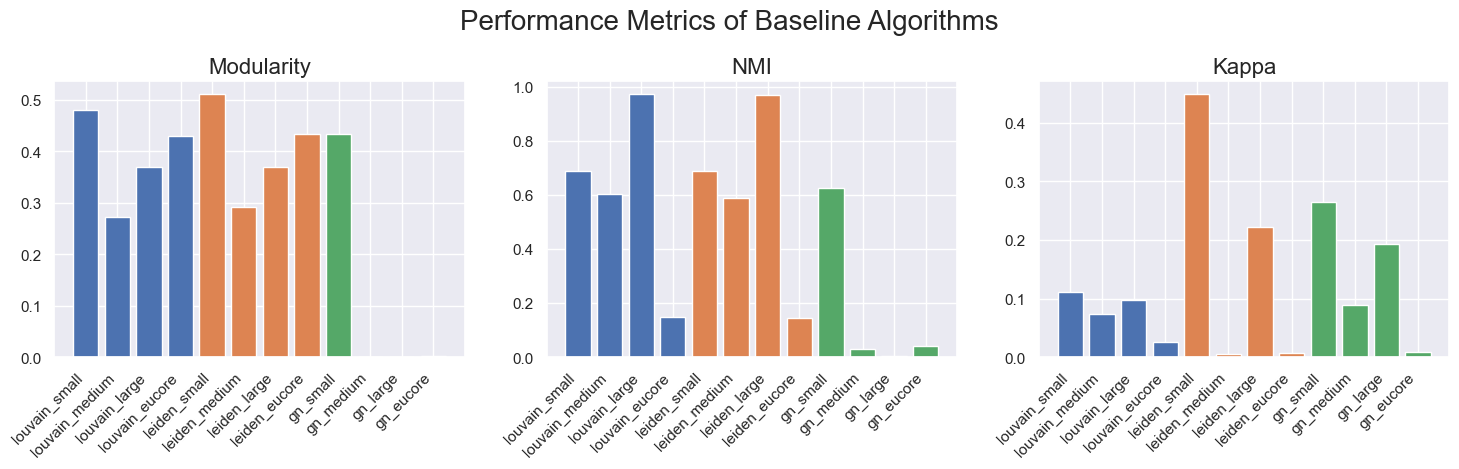

In [40]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

# modularity
ax[0].bar([key for key in res], modularities, color=colors)
ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[0].set_title("Modularity", fontsize=16)


# nmi
ax[1].bar([key for key in res], nmis, color=colors)
ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[1].set_title("NMI", fontsize=16)

# kappa
ax[2].bar([key for key in res], kappas, color=colors)
ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[2].set_title("Kappa", fontsize=16)

plt.subplots_adjust(top=0.8)
plt.suptitle("Performance Metrics of Baseline Algorithms", fontsize=20)


In [41]:
res_flow_capacity = {}
alpha_mod = {}

# Flow Capacity

## Flow Capacity Louvain

In [42]:
def flow_capacity_louvain_mod(G, quality="m"):
    metrics = []
    alpha_vals = np.arange(0,1, 0.1)
    gcl = create_gcl(G)
    
    for alpha in alpha_vals: #training
        A = nx.adjacency_matrix(G, weight=None)
        I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
        F = (1-alpha)*A + alpha*I
        F = nx.from_numpy_array(F)
        # ---------------------------------- running algorithm --------------------------------- #

 
        generated_communities = [nx.community.louvain_communities(F, weight="weight") for _ in tqdm.tqdm(range(5))]


        if quality == "m":   # metric = modularity
            metrics.append(np.mean([nx.community.modularity(G,c) for c in generated_communities]))

        else:
            l = []

            for comms in generated_communities:
                comms = [frozenset(i) for i in comms]
                lcl = create_lcl(comms,G)

                if quality == "n":
                    l.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl)) # metric nmi
                else:
                    l.append(total_kappa(gcl, lcl)) # metric kappa

            metrics.append(np.mean(l)) 



    # ------------------------- applying trained version ------------------------- #

    alpha_index, max_metric = metrics.index(max(metrics)), max(metrics) #gets index with highest alpha value, gets highest metric value
    max_alpha = alpha_vals[alpha_index]

    I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
    F = (1-max_alpha)*A + max_alpha*I
    
    F = nx.from_numpy_array(F)

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #


    generated_communities = [nx.community.louvain_communities(F) for _ in range(10)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(15):
        counter =0
        comms = nx.community.louvain_communities(F)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    
    return stats_dict, max_alpha, metrics

In [43]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_small, quality="q")
res_flow_capacity["louvain_small_modularity"] =  stats
alpha_mod["louvain_small_modularity"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00, 499.92it/s]


In [44]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_small, quality="k")
res_flow_capacity["louvain_small_kappa"] =  stats
alpha_mod["louvain_small_kappa"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00, 624.93it/s]


In [45]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium, quality="q")
res_flow_capacity["louvain_medium_nmi"] =  stats
alpha_mod["louvain_medium_nmi"] = [alpha, max_mod]


100%|██████████| 5/5 [00:00<00:00, 36.17it/s]


In [46]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium, quality="k")
res_flow_capacity["louvain_medium_kappa"] =  stats
alpha_mod["louvain_medium_kappa"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00, 38.16it/s]


In [47]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium, quality="n")
res_flow_capacity["louvain_medium_nmi"] =  stats
alpha_mod["louvain_medium_nmi"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00, 38.16it/s]


In [48]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_large, quality="n")
res_flow_capacity["louvain_large_nmi"] =  stats
alpha_mod["louvain_large_nmi"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


In [49]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="k")
res_flow_capacity["louvain_eucore_kappa"] =  stats
alpha_mod["louvain_eucore_kappa"] = [alpha, max_mod]

stats, alpha, max_mod

100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


({'a_modularity': 0.42954348459164116,
  'var_modularity': 1.3414440224510454e-05,
  'a_nmi': 0.15138906874269423,
  'var_nmi': 2.80702059735012e-05,
  'a_kappa': 0.012653593063520012,
  'var_kappa': 3.161607814623122e-05,
  'accuracy': 0.0045797851666204295},
 0.7000000000000001,
 [0.012120648508126193,
  0.016717295298397907,
  0.009322689592308624,
  0.01451889900739839,
  0.010521814841944727,
  0.020114816839033527,
  0.013519627966034972,
  0.031706360918849166,
  0.024311755212759877,
  0.02271292154657841])

In [50]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="q")
res_flow_capacity["louvain_eucore_modularity"] =  stats
alpha_mod["louvain_eucore_modularity"] = [alpha, max_mod]


stats, alpha, max_mod

100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


({'a_modularity': 0.4308113948318984,
  'var_modularity': 1.4266143322094446e-05,
  'a_nmi': 0.14693938219347383,
  'var_nmi': 4.322005109313833e-05,
  'a_kappa': 0.016783913367822135,
  'var_kappa': 0.00023731585665238183,
  'accuracy': 0.006599293793486459},
 0.8,
 [0.01631758688185254,
  0.017316857923215957,
  0.007124293301309109,
  0.02051452525557889,
  0.018116274756306693,
  0.02511117204585061,
  0.008523272759217892,
  0.019515254214215478,
  0.02990767304439501,
  0.014319044799125704])

In [51]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="n")
res_flow_capacity["louvain_eucore_nmi"] =  stats
alpha_mod["louvain_eucore_nmi"] = [alpha, max_mod]

stats, alpha, max_mod

100%|██████████| 5/5 [00:00<00:00,  7.37it/s]


({'a_modularity': 0.4315225206600434,
  'var_modularity': 2.0949752067445e-06,
  'a_nmi': 0.14950051629316813,
  'var_nmi': 5.334870031943355e-05,
  'a_kappa': 0.014385662868549937,
  'var_kappa': 9.341920900872644e-05,
  'accuracy': 0.005071807786184371},
 0.4,
 [0.153103021742071,
  0.15099496489365422,
  0.1504101802285676,
  0.14779116574970413,
  0.15493841341433506,
  0.14785141213549818,
  0.14644074604359159,
  0.14927273855943807,
  0.14881232519510135,
  0.1525026241637638])

## Flow Capacity Leidein

In [52]:
def flow_capacity_leiden(G, quality="m"):
    metrics = []
    alpha_vals = np.arange(0,1, 0.1)
    gcl = create_gcl(G)
    
    for alpha in alpha_vals: #training
        A = nx.adjacency_matrix(G, weight=None)
        I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
        F = (1-alpha)*A + alpha*I
        F = nx.from_numpy_array(F)
        # ---------------------------------- running algorithm --------------------------------- #

 
        generated_communities = [run_leiden(F) for _ in tqdm.tqdm(range(10))]


        if quality == "m":   # metric = modularity
            metrics.append(np.mean([nx.community.modularity(G,c) for c in generated_communities]))

        else:
            l = []

            for comms in generated_communities:
                comms = [frozenset(i) for i in comms]
                lcl = create_lcl(comms,G)

                if quality == "n":
                    l.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl)) # metric nmi
                else:
                    l.append(total_kappa(gcl, lcl)) # metric kappa

            metrics.append(np.mean(l)) 



    # ------------------------- applying trained version ------------------------- #

    alpha_index, max_metric = metrics.index(max(metrics)), max(metrics) #gets index with highest alpha value, gets highest metric value
    max_alpha = alpha_vals[alpha_index]

    I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
    F = (1-max_alpha)*A + max_alpha*I
    
    F = nx.from_numpy_array(F)

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #


    generated_communities = [run_leiden(F) for _ in tqdm.tqdm(range(10))]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(15):
        counter =0
        comms = nx.community.louvain_communities(F)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    
    return stats_dict, max_alpha, metrics

## Flow Capacity GN

In [53]:
def flow_capacity_gn(G, quality="m"):
    metrics = []
    alpha_vals = np.arange(0,1, 0.1)
    gcl = create_gcl(G)
    
    for alpha in tqdm.tqdm(alpha_vals): #training
        A = nx.adjacency_matrix(G, weight=None)
        I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
        F = (1-alpha)*A + alpha*I
        F = nx.from_numpy_array(F)
        # ---------------------------------- running algorithm --------------------------------- #

 
        nx.community.girvan_newman(G)
        comp = nx.community.girvan_newman(G)
        gn = tuple(sorted(c) for c in next(comp))

        generated_communities = [{frozenset(c) for c in gn}] 


        if quality == "m":   # metric = modularity
            metrics.append(np.mean([nx.community.modularity(G,c) for c in generated_communities]))

        else:
            l = []

            for comms in generated_communities:
                comms = frozenset(generated_communities[0]) 
                lcl = create_lcl(comms,G)

                if quality == "n":
                    l.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl)) # metric nmi
                else:
                    l.append(total_kappa(gcl, lcl)) # metric kappa

            metrics.append(np.mean(l)) 



    # ------------------------- applying trained version ------------------------- #

    alpha_index, max_metric = metrics.index(max(metrics)), max(metrics) #gets index with highest alpha value, gets highest metric value
    max_alpha = alpha_vals[alpha_index]

    I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
    F = (1-max_alpha)*A + max_alpha*I
    
    F = nx.from_numpy_array(F)

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #


    nx.community.girvan_newman(G)
    comp = nx.community.girvan_newman(G)
    gn = tuple(sorted(c) for c in next(comp))

    generated_communities = [{frozenset(c) for c in gn}] 
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(1):
        counter =0
        comms = nx.community.louvain_communities(F)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    
    return stats_dict, max_alpha, metrics

In [54]:
stats, alpha, max_mod = flow_capacity_leiden(G_small, quality="q")
res_flow_capacity["leiden_small_modularity"] =  stats
alpha_mod["leiden_small_modularity"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(G_medium, quality="q")
res_flow_capacity["leiden_medium_modularity"] =  stats
alpha_mod["leiden_medium_modularity"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(G_large, quality="q")
res_flow_capacity["leiden_large_modularity"] =  stats
alpha_mod["leiden_large_modularity"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(eucore, quality="q")
res_flow_capacity["leiden_eucore_modularity"] =  stats
alpha_mod["leiden_eucore_modularity"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 32.25it/s]


In [55]:
stats, alpha, max_mod = flow_capacity_leiden(G_small, quality="k")
res_flow_capacity["leiden_small_kappa"] =  stats
alpha_mod["leiden_small_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(G_medium, quality="k")
res_flow_capacity["leiden_medium_kappa"] =  stats
alpha_mod["leiden_medium_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(G_large, quality="k")
res_flow_capacity["leiden_large_kappa"] =  stats
alpha_mod["leiden_large_kappa"] = [alpha, max_mod]


stats, alpha, max_mod = flow_capacity_leiden(eucore, quality="k")
res_flow_capacity["leiden_eucore_kappa"] =  stats
alpha_mod["leiden_eucore_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 34.45it/s]


In [56]:
stats, alpha, max_mod = flow_capacity_leiden(G_small, quality="n")
res_flow_capacity["leiden_small_nmi"] =  stats
alpha_mod["leiden_small_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(G_medium, quality="n")
res_flow_capacity["leiden_medium_nmi"] =  stats
alpha_mod["leiden_medium_kappa"] = [alpha, max_mod]


stats, alpha, max_mod = flow_capacity_leiden(G_large, quality="n")
res_flow_capacity["leiden_large_nmi"] =  stats
alpha_mod["leiden_large_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(eucore, quality="n")
res_flow_capacity["leiden_eucore_nmi"] =  stats
alpha_mod["leiden_eucore_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 34.49it/s]


In [57]:
stats, alpha, max_mod = flow_capacity_gn(G_small, quality="n")
res_flow_capacity["gn_small_nmi"] =  stats
alpha_mod["gn_small_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_gn(G_medium, quality="n")
res_flow_capacity["gn_medium_nmi"] =  stats
alpha_mod["gn_medium_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_gn(G_medium, quality="n")
res_flow_capacity["gn_large_nmi"] =  stats
alpha_mod["gn_large_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_gn(eucore, quality="n")
res_flow_capacity["gn_eucore_nmi"] =  stats
alpha_mod["gn_eucore_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [10:40<00:00, 64.07s/it]


# Graphing


In [58]:
modularities = [res_flow_capacity[key]["a_modularity"] for key in res_flow_capacity ]
nmis = [res_flow_capacity[key]["a_nmi"] for key in res_flow_capacity ]
kappas = [res_flow_capacity[key]["a_kappa"] for key in res_flow_capacity ]



colors = [label_colors[str(key).split("_")[0]] for key in res_flow_capacity]
res.keys()


dict_keys(['louvain_small', 'louvain_medium', 'louvain_large', 'louvain_eucore', 'leiden_small', 'leiden_medium', 'leiden_large', 'leiden_eucore', 'gn_small', 'gn_medium', 'gn_large', 'gn_eucore'])

C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_17328\4056941909.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_17328\4056941909.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_17328\4056941909.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")


Text(0.5, 0.98, 'Performance Metrics of Flow-Capacity Algorithms')

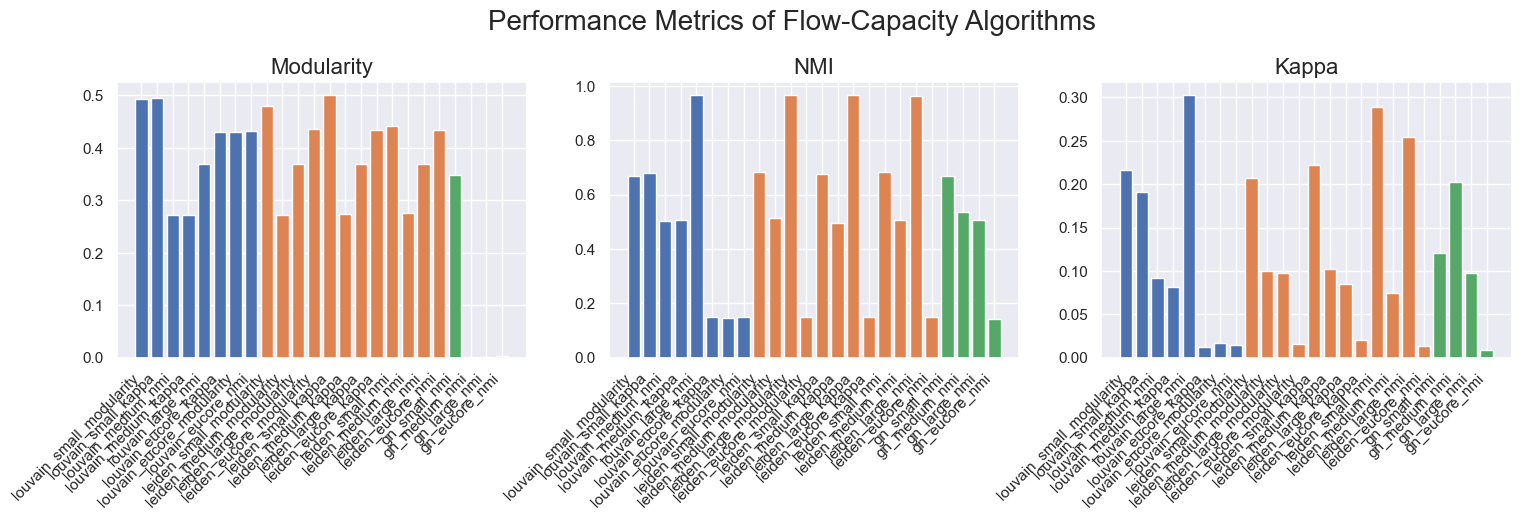

In [59]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

# modularity
ax[0].bar([key for key in res_flow_capacity], modularities, color=colors)
ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[0].set_title("Modularity", fontsize=16)


# nmi
ax[1].bar([key for key in res_flow_capacity], nmis, color=colors)
ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[1].set_title("NMI", fontsize=16)

# kappa
ax[2].bar([key for key in res_flow_capacity], kappas, color=colors)
ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[2].set_title("Kappa", fontsize=16)

plt.subplots_adjust(top=0.8)
plt.suptitle("Performance Metrics of Flow-Capacity Algorithms", fontsize=20)

In [60]:
louvain = [s for s in res.keys() if s.split("_")[0] == "louvain"]
gn = [s for s in res.keys() if s.split("_")[0] == "gn"]
leiden = [s for s in res.keys() if s.split("_")[0] == "leiden"]

In [61]:
louvain_mod = [res[k]["a_modularity"] for k in louvain ][0:4]
leiden_mod = [res[k]["a_modularity"] for k in leiden ]
gn_mod = [res[k]["a_modularity"] for k in gn ]


In [62]:
louvain_nmi = [res[k]["a_nmi"] for k in louvain ][0:4]
leiden_nmi = [res[k]["a_nmi"] for k in leiden ]
gn_nmi = [res[k]["a_nmi"] for k in gn ]


In [63]:
louvain_kappa = [res[k]["a_kappa"] for k in louvain ][0:4]
leiden_kappa = [res[k]["a_kappa"] for k in leiden ]
gn_kappa = [res[k]["a_kappa"] for k in gn ]

In [64]:
x_labels = ["small50", "medium250","large250", "eucore"]

In [75]:
def mod_graph(G):    
    ground = {frozenset(G.nodes[v]["community"]) for v in G}
    mod = nx.community.modularity(G, ground)
    return mod

x =[mod_graph(G) for G in [G_small, G_medium, G_large]] 
x.append( 0.29999818295402103)
base_mods = x

In [67]:
dill.dump_session("exp")

In [76]:
base_mods

[0.44956956105856094,
 0.20706793739429247,
 0.3688014109733919,
 0.29999818295402103]

Text(0.5, 0.98, 'Resulting For the Baseline implementations')

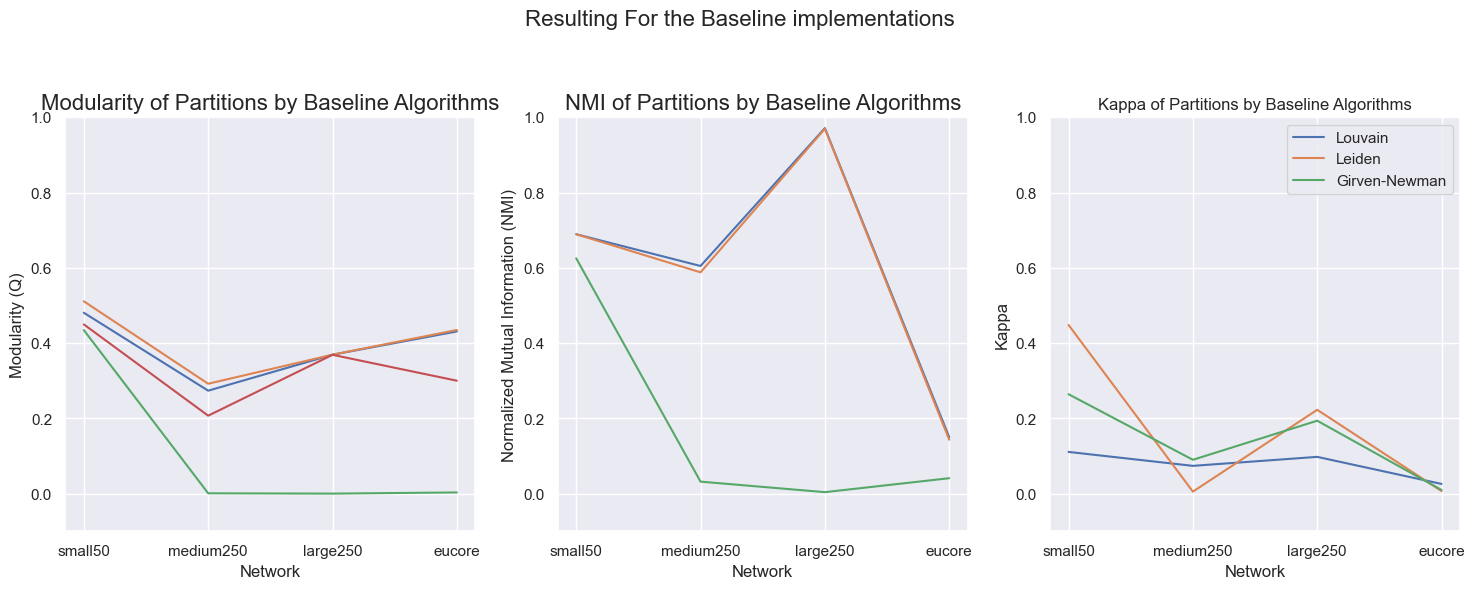

In [100]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].plot(x_labels, louvain_mod)
ax[0].plot(x_labels, leiden_mod)
ax[0].plot(x_labels, gn_mod)
ax[0].plot(x_labels, base_mods)

plt.legend(["Louvain", "Leiden", "Girven-Newman", "Real Modularity"])
ax[0].set_ylabel("Modularity (Q)")
ax[0].set_xlabel("Network")
ax[0].set_ylim(-0.1,1)
ax[0].set_title("Modularity of Partitions by Baseline Algorithms", fontsize=16)

ax[1].plot(x_labels, louvain_nmi)
ax[1].plot(x_labels, leiden_nmi)
ax[1].plot(x_labels, gn_nmi)


plt.legend(["Louvain", "Leiden", "Girven-Newman", "Real Modularity"])
ax[1].set_ylabel("Normalized Mutual Information (NMI)")
ax[1].set_xlabel("Network")
ax[1].set_ylim(-0.1,1)
ax[1].set_title("NMI of Partitions by Baseline Algorithms", fontsize=16)


ax[2].plot(x_labels, louvain_kappa)
ax[2].plot(x_labels, leiden_kappa)
ax[2].plot(x_labels, gn_kappa)
ax[2].set_ylim(-0.1,1)


plt.legend(["Louvain", "Leiden", "Girven-Newman"])
ax[2].set_ylabel("Kappa")
ax[2].set_xlabel("Network")
plt.title("Kappa of Partitions by Baseline Algorithms", fontsize=12)


plt.subplots_adjust(top=0.8)
plt.suptitle("Resulting For the Baseline implementations", fontsize=16)


In [135]:
len(res_flow_capacity)

24

In [125]:
modularities = [res_flow_capacity[key]["a_modularity"] for key in res_flow_capacity ]
mod_baseline = [res[key]["a_modularity"] for key in res ]

m = []
l = []
for i in range(len(modularities)):
    if i % 4 == 0:
        m.append(l)
        l = []
        l.append(modularities[i])
    else:
        l.append(modularities[i])

m.remove([])

In [137]:
res_flow_capacity.keys()

dict_keys(['louvain_small_modularity', 'louvain_small_kappa', 'louvain_medium_nmi', 'louvain_medium_kappa', 'louvain_large_nmi', 'louvain_eucore_kappa', 'louvain_eucore_modularity', 'louvain_eucore_nmi', 'leiden_small_modularity', 'leiden_medium_modularity', 'leiden_large_modularity', 'leiden_eucore_modularity', 'leiden_small_kappa', 'leiden_medium_kappa', 'leiden_large_kappa', 'leiden_eucore_kappa', 'leiden_small_nmi', 'leiden_medium_nmi', 'leiden_large_nmi', 'leiden_eucore_nmi', 'gn_small_nmi', 'gn_medium_nmi', 'gn_large_nmi', 'gn_eucore_nmi'])

In [140]:
modularities_labels = [key for key in res_flow_capacity if key.split("_")[2] == "modularity"]
modularities_labels

['louvain_small_modularity',
 'louvain_eucore_modularity',
 'leiden_small_modularity',
 'leiden_medium_modularity',
 'leiden_large_modularity',
 'leiden_eucore_modularity']

In [ ]:
dill.dump_session("exp")

{'louvain_small_modularity': {'a_modularity': 0.4931036773302157,
  'var_modularity': 6.281327311638286e-05,
  'a_nmi': 0.6690336448929682,
  'var_nmi': 0.0002537013217674013,
  'a_kappa': 0.21639492605493685,
  'var_kappa': 0.025833658811953573,
  'accuracy': 0.1962355045332566},
 'louvain_small_kappa': {'a_modularity': 0.49520804548836217,
  'var_modularity': 0.00020036231183499618,
  'a_nmi': 0.6796408967992547,
  'var_nmi': 0.0017196532748281984,
  'a_kappa': 0.19050188882892607,
  'var_kappa': 0.02728970399589115,
  'accuracy': 0.17917890481329127},
 'louvain_medium_nmi': {'a_modularity': 0.2721343585062686,
  'var_modularity': 4.826323992965202e-06,
  'a_nmi': 0.501339077742608,
  'var_nmi': 0.000953006110307398,
  'a_kappa': 0.09173007534468187,
  'var_kappa': 0.004597091509676207,
  'accuracy': 0.0610754925359595},
 'louvain_medium_kappa': {'a_modularity': 0.27216366828639693,
  'var_modularity': 3.780041486306278e-05,
  'a_nmi': 0.5085331697338773,
  'var_nmi': 0.0011715380654

NotAPartition: [(14, 53, 65, 93, 95, 129, 133, 167, 168, 172, 176, 183, 197, 198, 199, 200, 201, 202, 203, 206, 207, 232, 256, 270, 275, 276, 280, 290, 291, 292, 294, 399, 401, 403, 413, 419, 425, 426, 440, 450, 457, 458, 464, 484, 486, 493, 515, 522, 523, 526, 534, 542, 543, 544, 556, 562, 563, 567, 568, 572, 574, 576, 584, 585, 600, 611, 620, 623, 626, 655, 664, 688, 689, 694, 702, 705, 706, 714, 727, 732, 744, 749, 789, 790, 791, 801, 802, 813, 817, 822, 829, 835, 836, 840, 843, 844, 850, 874, 902, 909, 910, 936, 938, 940, 959, 961, 965, 992, 1000), (134, 340, 482, 521, 553, 554, 583, 598, 766, 862), (268, 331, 756), (16, 42, 87, 105, 212, 424, 434, 460, 561, 607, 684, 763, 787), (66, 90, 108, 110, 111, 112, 143, 258, 328, 329, 356, 357, 375, 475, 477, 478, 514, 652, 989), (102, 106, 173, 300, 405, 638, 771, 773, 828, 889, 891, 892, 896), (77, 78, 79, 445, 483, 497, 531, 539, 557, 581, 811, 848), (253, 471, 507, 560, 726, 759, 831, 875), (5, 6, 64, 489, 528, 644), (10, 20, 21, 22, 72, 92, 259, 260, 306, 325, 326, 327, 400, 416, 524, 535, 538, 703, 723, 733, 777, 825, 858, 881, 885, 887, 890, 894, 923, 945, 962, 975), (15, 45, 46, 139, 140, 164, 216, 269, 272, 273, 274, 322, 334, 335, 428, 429, 446, 447, 448, 461, 579, 592, 617, 657, 660, 676, 735, 760, 794, 796, 819, 838, 854, 929, 933), (41, 51, 94, 128, 196, 204, 205, 593, 751, 776, 820, 861, 908, 917, 918, 955, 970, 974), (122, 130, 148, 149, 156, 157, 178, 179, 180, 191, 214, 231, 257, 262, 277, 278, 284, 289, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 402, 511, 575, 621, 656, 668, 680, 681, 682, 692, 712, 781, 814, 824, 839, 851, 857, 871, 903, 907), (47, 48, 75, 76, 113, 114, 119, 151, 171, 229, 245, 261, 263, 318, 333, 361, 367, 370, 417, 423, 442, 443, 444, 485, 527, 547, 704, 725, 753, 757, 795, 847, 895, 897, 919, 925, 976, 981, 983), (117, 127, 255, 435, 453, 472, 490, 491, 537, 548, 610, 613, 616, 619, 642, 647, 659, 686, 745, 782, 834, 837, 939, 942, 948, 960, 995, 1003), (50, 70, 71, 84, 152, 162, 217, 288, 364, 431, 432, 433, 612, 643, 654), (147, 230, 279, 465, 495, 512, 519, 541, 589, 591, 596, 597, 641, 669, 673, 695, 730, 742, 748, 783, 786, 793, 906, 920, 944, 946, 979), (767,), (97, 98, 99, 100, 101, 124, 125, 185, 323, 353, 354, 371, 404, 580, 618, 640, 662, 687, 708, 709, 768, 770, 842, 935, 937), (163, 614, 717, 788, 792, 821), (144, 186, 254, 492), (174, 175, 665, 812, 859, 886, 888, 971, 991), (427, 470, 980), (1, 17, 18, 73, 74, 85, 120, 177, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 248, 297, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 341, 414, 415, 449, 459, 468, 479, 516, 517, 603, 605, 629, 645, 650, 675, 696, 697, 731, 734, 743, 764, 775, 797, 798, 846, 852, 872, 904, 905, 916, 1002), (88, 89, 96, 252, 302, 303, 304, 369, 630, 740, 750, 806, 808, 924), (145, 154, 155, 363, 422, 513, 518, 533, 546, 615, 934, 954, 984), (49, 62, 82, 83, 86, 107, 121, 142, 160, 166, 282, 283, 366, 372, 373, 494, 594, 601, 693, 752, 932, 950), (109, 153, 355, 410, 454, 559, 577, 578, 736, 769), (13, 118, 301, 409, 420, 624, 651, 677, 810), (870,), (115, 116, 123, 135, 136, 165, 169, 170, 251, 330, 336, 337, 338, 339, 436, 437, 438, 439, 609, 724, 816, 860, 883, 900, 914, 978), (462, 463, 701, 876), (158, 159, 209, 210, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 319, 564, 599, 631, 637, 639, 879, 926, 927, 930, 931, 963, 977), (80, 671, 679, 716, 966), (52, 60, 61, 103, 104, 150, 181, 182, 250, 295, 296, 320, 321, 368, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 628, 632, 653, 719, 741, 761, 772, 841, 853, 868, 869, 943, 947, 985), (758, 941), (2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 193, 194, 195, 281, 286, 305, 408, 412, 456, 520, 532, 571, 586, 587, 606, 622, 625, 633, 634, 635, 636, 648, 670, 685, 691, 711, 718, 755, 762, 774, 803, 815, 826, 832, 845, 849, 863, 865, 880, 882, 884, 899, 901, 921, 928, 982, 990, 993, 994, 1001), (131, 132, 271, 411, 737, 784, 807, 864), (54, 55, 126, 208, 211, 285, 455, 469, 481, 552, 604, 646, 683, 698, 728, 738, 809, 866, 867, 898, 949, 986, 987, 988, 1004), (7, 8, 9, 11, 12, 19, 43, 44, 141, 161, 213, 246, 247, 249, 264, 265, 266, 267, 293, 324, 332, 358, 359, 360, 362, 365, 374, 406, 407, 421, 430, 441, 451, 452, 466, 487, 488, 496, 498, 499, 500, 501, 502, 503, 504, 505, 506, 510, 525, 529, 530, 555, 558, 565, 566, 569, 570, 573, 602, 608, 649, 658, 661, 666, 672, 674, 699, 700, 707, 720, 729, 739, 754, 765, 804, 805, 823, 827, 830, 833, 856, 893, 912, 913, 922, 951, 956, 957, 967, 973, 996, 998), (67, 68, 69, 81, 91, 146, 184, 187, 188, 189, 190, 287, 298, 299, 418, 467, 473, 474, 476, 480, 508, 509, 536, 540, 549, 550, 551, 582, 595, 627, 663, 667, 678, 690, 710, 713, 715, 746, 747, 778, 779, 780, 799, 800, 818, 855, 873, 877, 911, 952, 958, 968, 969, 972, 999), (23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 545, 588, 590, 721, 722, 785, 878, 915, 953, 964, 997)] is not a valid partition of the graph Graph with 1005 nodes and 16704 edges

In [ ]:
mod_graph(eucore)

KeyError: 'community'